# Human Image Segmentation using U-NET
<hr>


<div style="display:flex; align-items:center;">
    <img src="human.jpeg" alt="U-Net Architecture" style="width:500px;height:300px;">
    <p style="margin-left: 20px;">Image segmentation refers to the process of partitioning an image into multiple segments or regions to simplify its representation and facilitate understanding. This technique divides an image into meaningful parts, such as objects or regions with shared characteristics, making it easier to analyze and extract relevant information.<br><br> 
  This method plays a pivotal role in various domains by facilitating precise object delineation, aiding in tasks like object detection, semantic understanding, and facilitating targeted analysis in fields such as medical imaging, autonomous vehicles, and object recognition systems.<br><br> Human image segmentation involves precisely delineating human figures within images, separating them from the background. This technique aids in tasks like human pose estimation, activity recognition, and person-centric analysis in various applications.</p>
</div>



 <i>The project aims to develop an intelligent system capable of accurately segmenting humans from images using deep learning techniques. Human image segmentation plays a crucial role in various applications such as medical imaging, video surveillance, and augmented reality.</i>
<hr>

In [1]:
import os
import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
import numpy as np
import pandas as pd

from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import os
import random

### Data preparation 

In [2]:
# Function for loading images 

def load_images_as_numpy(folder_path, limit=None):
    image_list = []
    count = 0
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)
            img = img.resize((256,256))  
            img = img.convert("RGB")  
            img_array = np.array(img)
            image_list.append(img_array)
            count += 1
            if limit is not None and count >= limit:
                break
    return np.stack(image_list)

# link your dataset folder here 
frames_folder = r'C:\Users\subar\OneDrive\Desktop\Machine Learning\ChiSquareX\Image Cropper\Data_set\data_images'  
masks_folder = r'C:\Users\subar\OneDrive\Desktop\Machine Learning\ChiSquareX\Image Cropper\Data_set\annotated_images'
limit = 127  
frames_array = load_images_as_numpy(frames_folder, limit=limit)
masks_array = load_images_as_numpy(masks_folder, limit=limit)

print("Frames shape:", frames_array.shape)
print("Masks shape:", masks_array.shape)

Frames shape: (127, 256, 256, 3)
Masks shape: (127, 256, 256, 3)


## Train and Validation Data

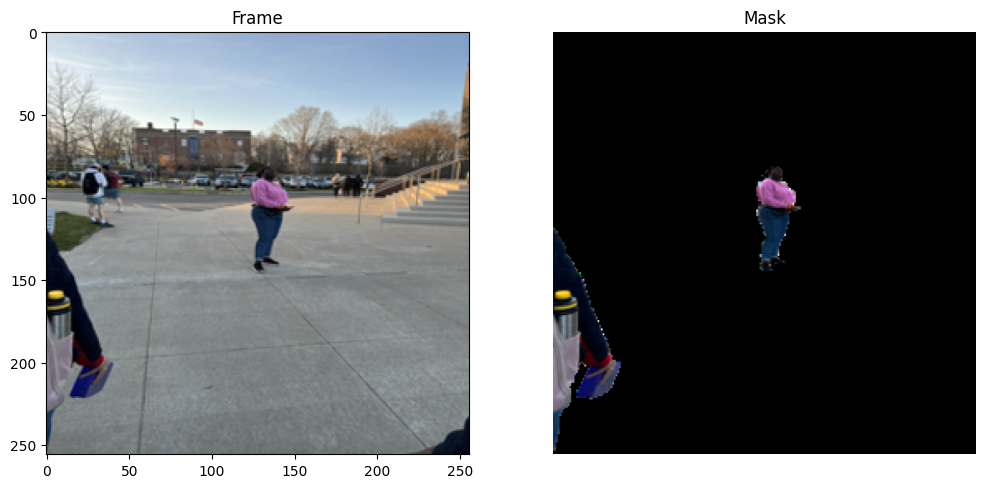

In [3]:
import matplotlib.pyplot as plt

index_to_visualize = 0

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the frame
plt.axis('off')
axs[0].imshow(frames_array[index_to_visualize])

axs[0].set_title('Frame')

# Plot the mask
plt.axis('off')
axs[1].imshow(masks_array[index_to_visualize], cmap='gray')
plt.axis('off')
axs[1].set_title('Mask')

plt.show()

## Preprocessing label images

### Simplifying Segmentation

Converting RGB labels to black and white masks simplifies segmentation by reducing output classes. Through thresholding, it generates binary masks where white denotes humans and black represents backgrounds. Binary masks focus the model on discerning humans from backgrounds, streamlining its task. This reduction in complexity enhances training efficiency significantly.



In [4]:
def process_masks(masks_array):
    averaged_array = np.mean(masks_array, axis=-1, keepdims=True)  
    new_masks_array = np.where(averaged_array > 0, 1, 0)  
    return new_masks_array

processed_masks = process_masks(masks_array)

In [5]:
processed_masks.shape

(127, 256, 256, 1)

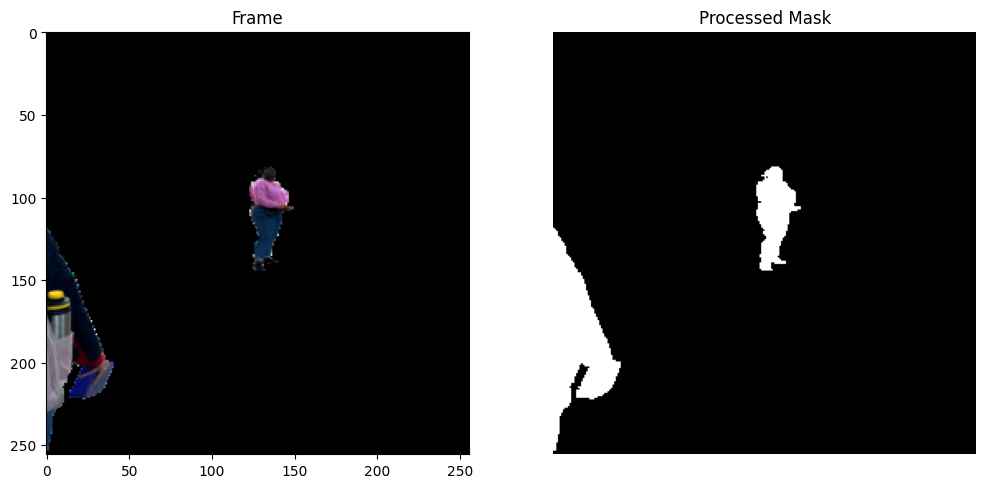

In [6]:
import matplotlib.pyplot as plt

index_to_visualize = 0

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.axis('off')

axs[0].imshow(masks_array[index_to_visualize])

axs[0].set_title('Frame')

# Plot the mask

axs[1].imshow(processed_masks[index_to_visualize], cmap='gray')

axs[1].set_title('Processed Mask')

plt.show()

## Dataloader

DataLoaders efficiently handle dataset management, providing seamless batch-wise access during model training in PyTorch. They facilitate parallel data loading, shuffling, and batching, optimizing the training process.

In [7]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

from segmentation_models_pytorch import Unet
import segmentation_models_pytorch as smp


frames_tensor = torch.tensor(frames_array, dtype=torch.float32).permute(0, 3, 1, 2)  # Assuming channels are in the last dimension
masks_tensor = torch.tensor(processed_masks, dtype=torch.float32).permute(0, 3, 1, 2)


frames_tensor /= 255.0


dataset = TensorDataset(frames_tensor, masks_tensor)


train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# U-Net Architecture

The U-Net architecture is a convolutional neural network commonly used for image segmentation tasks. It comprises an encoder-decoder structure with skip connections, enabling precise pixel-wise segmentation.

#### Encoder
The encoder path consists of successive down-sampling blocks, typically convolutional layers followed by pooling layers (e.g., max pooling). These layers extract high-level features while reducing spatial dimensions.

#### Decoder
The decoder path involves up-sampling blocks to recover the spatial information lost during encoding. Each block typically includes up-convolutions (transpose convolutions or upsampling) followed by convolutional layers. These layers help in learning detailed segmentation information.

#### Skip Connections
Skip connections connect corresponding layers between the encoder and decoder paths. These connections concatenate feature maps from the encoder to the decoder, allowing the decoder to access low-level details for precise segmentation.

#### Output Layer
The final layer often involves a convolutional layer with a softmax or sigmoid activation function, producing pixel-wise segmentation masks corresponding to different classes in the image.

![U-Net Architecture](unet.png)

## Model Training and Fine-tuning

Here U-Net architecture with a ResNet34 backbone is used. U-Net is known for its encoder-decoder structure, while ResNet34 comprises a deep neural network architecture with skip connections. These skip connections facilitate information flow and help mitigate vanishing gradient issues in deeper networks.

By setting encoder_weights='imagenet', the model's encoder (backbone) utilizes weights pre-trained on the ImageNet dataset. ImageNet is a vast dataset containing millions of images across numerous categories, enabling models pre-trained on it to capture rich hierarchical features and patterns.

### Fine-tuning Process:
Fine-tuning involves taking a pre-trained model, like the U-Net with pre-trained ResNet34 weights, and adapting it to a specific dataset or task. During fine-tuning, the pre-trained weights, initially frozen, are gradually updated by training on a new dataset. The process might involve modifying the output layer and possibly selectively unfreezing specific layers or blocks. This adaptation enables the model to learn task-specific features while retaining the knowledge gained from the pre-training on ImageNet. Fine-tuning is a powerful strategy to enhance model performance and adaptability for new tasks, particularly when the available dataset is limited.

Epoch [1/40] - Train Loss: 0.5038 - Test Loss: 11.5497 - Elapsed Time: 26.61 seconds
Epoch [2/40] - Train Loss: 0.3009 - Test Loss: 0.4264 - Elapsed Time: 24.93 seconds
Epoch [3/40] - Train Loss: 0.2161 - Test Loss: 0.2940 - Elapsed Time: 25.20 seconds
Epoch [4/40] - Train Loss: 0.1631 - Test Loss: 0.1523 - Elapsed Time: 25.52 seconds
Epoch [5/40] - Train Loss: 0.1329 - Test Loss: 0.1335 - Elapsed Time: 25.12 seconds
Epoch [6/40] - Train Loss: 0.1280 - Test Loss: 0.1023 - Elapsed Time: 25.07 seconds
Epoch [7/40] - Train Loss: 0.1077 - Test Loss: 0.1061 - Elapsed Time: 24.81 seconds
Epoch [8/40] - Train Loss: 0.0824 - Test Loss: 0.1313 - Elapsed Time: 25.96 seconds
Epoch [9/40] - Train Loss: 0.0707 - Test Loss: 0.1059 - Elapsed Time: 26.17 seconds
Epoch [10/40] - Train Loss: 0.0630 - Test Loss: 0.0961 - Elapsed Time: 25.81 seconds
Epoch [11/40] - Train Loss: 0.0691 - Test Loss: 0.1586 - Elapsed Time: 25.72 seconds
Epoch [12/40] - Train Loss: 0.1072 - Test Loss: 0.1610 - Elapsed Time: 24

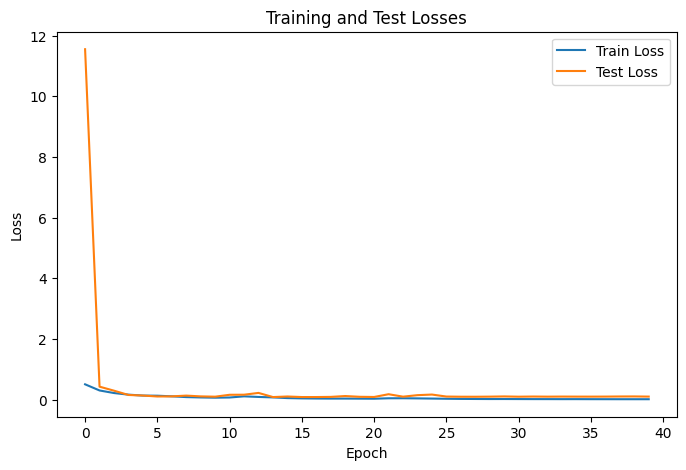

In [8]:

import matplotlib.pyplot as plt
import time


from timeit import default_timer as timer 
# Assuming train_loader and test_loader are defined

torch.manual_seed(42) 
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name="resnet34", encoder_weights='imagenet', in_channels=3, classes=1) 

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 40

model.to(device)

train_losses = []  
test_losses = []  

start_time = timer()



for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []  
    epoch_test_losses = []  

    start_time = time.time()

    # Training loop
    for frames, masks in train_loader:
        frames, masks = frames.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, masks)
        epoch_train_losses.append(loss.item()) 
        loss.backward()
        optimizer.step()

    epoch_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(epoch_train_loss)

    model.eval()
    with torch.no_grad():
        # Testing loop
        for frames, masks in test_loader:
            frames, masks = frames.to(device), masks.to(device)
            outputs = model(frames)

            test_loss = criterion(outputs, masks)
            epoch_test_losses.append(test_loss.item())

    epoch_test_loss = sum(epoch_test_losses) / len(epoch_test_losses)
    test_losses.append(epoch_test_loss)

    elapsed_time = time.time() - start_time
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_train_loss:.4f} - Test Loss: {epoch_test_loss:.4f} - Elapsed Time: {elapsed_time:.2f} seconds")

    
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

# Plotting the losses
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()
plt.show()



In [9]:
#torch.save(model, 'model2.pth');

#model = torch.load('model.pth')

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#model  =model.to(device)

### Model Predictions
The final figure displayed showcases the original frame, the ground truth mask, and the predicted mask side by side for comparison.

(127, 256, 256, 3)
torch.Size([127, 3, 256, 256])


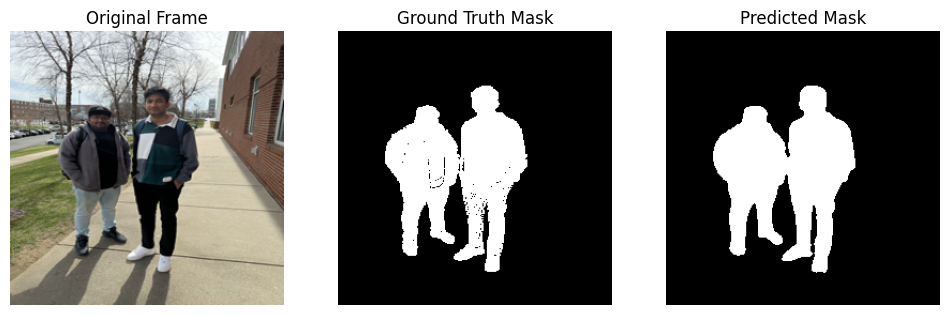

In [16]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def process_masks2(masks_array):
    new_masks_array = np.where(masks_array > 0, 1, 0)
    return new_masks_array


print(frames_array.shape)

frames_tensor = torch.tensor(frames_array, dtype=torch.float32).permute(0, 3, 1, 2)  # Assuming channels are in the last dimension


frames_tensor /= 255.0


frames_tensor = frames_tensor.to(device)


model.eval()


with torch.no_grad():
    predictions = model(frames_tensor)
    print(frames_tensor.shape)
    

predictions_np = predictions.cpu().numpy()

predictions_np =  process_masks2(predictions_np)




plt.figure(figsize=(12, 6))

        # Plot the original frame
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(frames_array[8])
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.imshow(processed_masks[8, ..., 0], cmap="gray")  # Assuming masks are grayscale
plt.axis('off')
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.imshow(predictions_np[8, 0], cmap="gray")
plt.axis('off')
plt.title("Predicted Mask")
plt.show()

Text(0.5, 1.0, 'Predicted Mask')

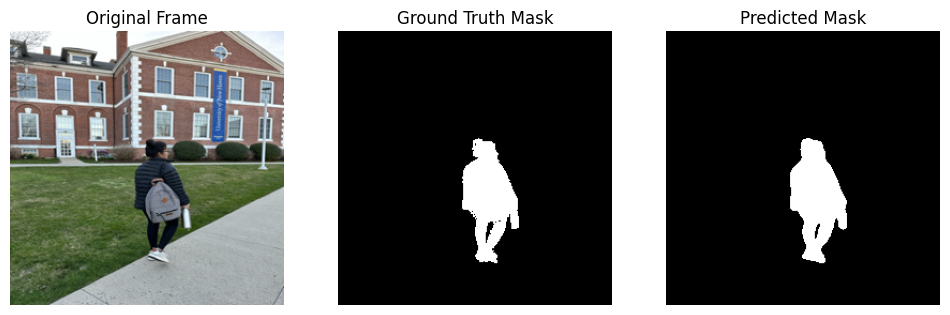

In [17]:
plt.figure(figsize=(12,6))

        # Plot the original frame
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(frames_array[102])
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(processed_masks[102, ..., 0], cmap="gray")  # Assuming masks are grayscale
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(predictions_np[102, 0], cmap="gray")
plt.title("Predicted Mask")
# plt.show()

Text(0.5, 1.0, 'Predicted Mask')

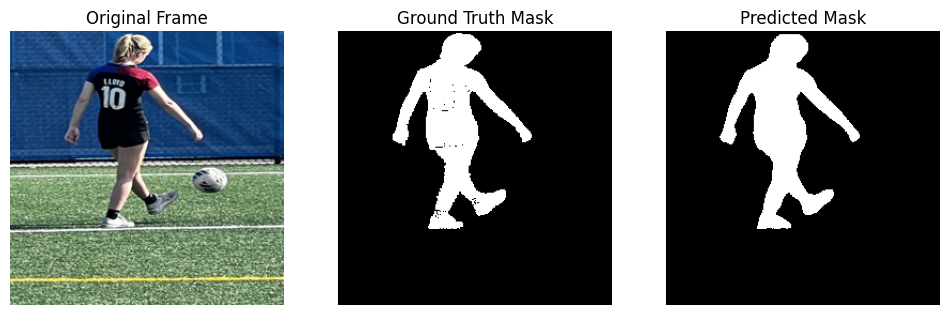

In [18]:
plt.figure(figsize=(12,6))

        # Plot the original frame
plt.subplot(1, 3, 1)
plt.imshow(frames_array[82])
plt.axis('off')
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(processed_masks[82, ..., 0], cmap="gray")  # Assuming masks are grayscale
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(predictions_np[82,0], cmap="gray")
plt.title("Predicted Mask")
# plt.show()

In [19]:
# import numpy as np
def dice_coefficient(predictions, targets):
    intersection = np.sum(predictions * targets)
    union = np.sum(predictions) + np.sum(targets)
    return (2.0 * intersection) / (union + intersection + 1e-8)  # Adding a small constant to avoid division by zero


# Threshold predictions (assuming binary masks with values between 0 and 1)
threshold = 0.5
binary_predictions = (predictions_np > threshold).astype(np.float32)

# Calculate Dice scores for each pair of masks
dice_scores = []
for i in range(binary_predictions.shape[0]):
    for channel in range(masks_array.shape[-1]):
        dice = dice_coefficient(binary_predictions[i, 0, :, :], masks_array[i, :, :, channel])
        dice_scores.append(dice)

# Calculate the average Dice score
average_dice_score = np.mean(dice_scores)
print("Average Dice Score:", average_dice_score)

Average Dice Score: 0.9641058853880855


In [22]:
predictions_np1 = np.transpose(predictions_np, (0, 2, 3, 1))


In [23]:
final_predictions = predictions_np1 * frames_array


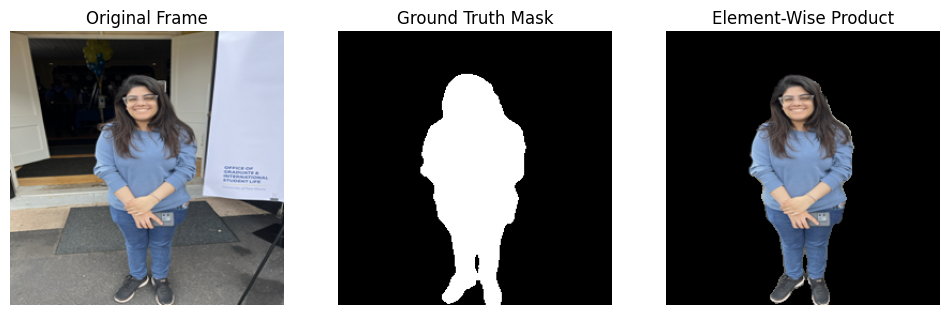

In [24]:
plt.figure(figsize=(12,6))

plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(frames_array[9])
plt.title("Original Frame")

        # Plot the ground truth mask
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(predictions_np[9,0], cmap="gray")  # Assuming masks are grayscale
plt.title("Ground Truth Mask")

        # Plot the predicted mask
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(final_predictions[9], cmap="gray")
plt.title("Element-Wise Product")
plt.show()

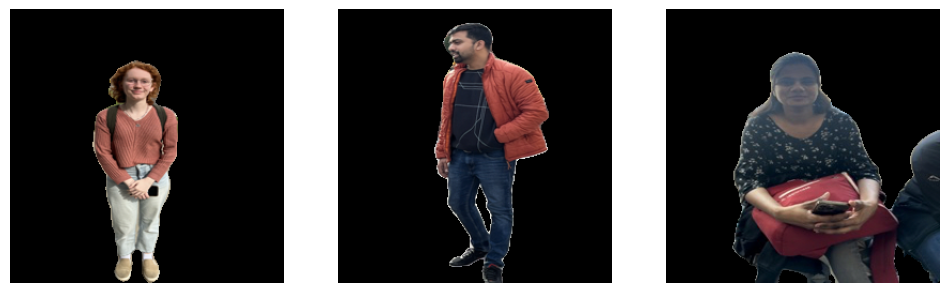

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
# plt.title("final prediction 1")
plt.imshow(final_predictions[12])
plt.axis('off')
plt.subplot(1, 3, 2)
# plt.title("final prediction 2")
plt.imshow(final_predictions[57])
plt.axis('off')
plt.subplot(1, 3, 3)
# plt.title("final prediction 3")
plt.imshow(final_predictions[119])
plt.axis('off')
plt.show()

## Custom Crop Function

Function that operates on an input image path to generate a segmented 

In [26]:
'''
def CustomCrop(path):
    img = Image.open(path)
    img = img.resize((256,256))  
    img = img.convert("RGB")  
    frame_array = np.array(img)
    frame = frame_array 
    frame_array =  frame_array [np.newaxis, ...]
    frame_tensor = torch.tensor(frame_array, dtype=torch.float32).permute(0, 3, 1, 2)
    frame_tensor /= 255.0
    model.eval()
    
    with torch.no_grad():
        prediction = model(frame_tensor)
    
    prediction = prediction.cpu().numpy()
    prediction = process_masks2(prediction)
    prediction = np.squeeze(prediction)
    prediction = np.expand_dims(prediction , axis=-1)
    prediction = prediction * frame
    plt.figure(figsize=(16,8))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    plt.imshow(frame)
    plt.title("Original Frame")

        # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.axis('off')
    plt.imshow(prediction)  
    plt.title("Mask")
    print(prediction.shape)
    
#     im = Image.fromarray(prediction)
#     im.save("your_file.png")

    image = prediction.astype(np.uint8)
    #image = np.squeeze(image)
    image = Image.fromarray(image)
    image.save("output_image.png")
'''

(256, 256, 3)


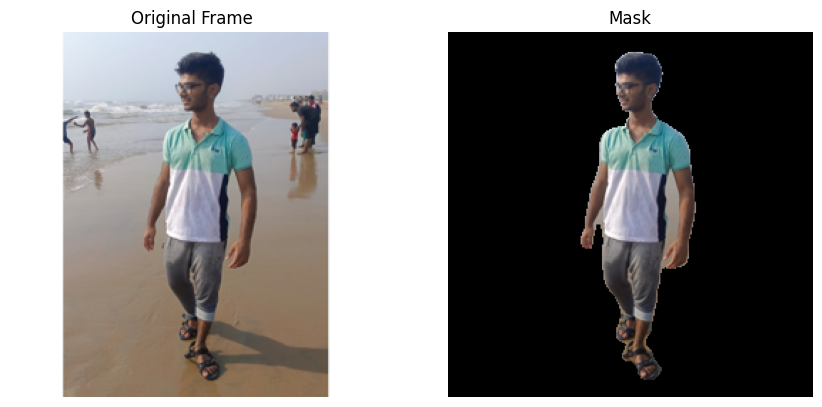

In [27]:
#CustomCrop("test.jpeg")